In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re #Regular Expressions
import string #importing string functions
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer

In [2]:
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc, precision_score,recall_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

In [3]:
df= pd.read_csv('CompanyReviews.csv')
df.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat


In [4]:
print("My data's shape is:", df.shape)

My data's shape is: (40046, 4)


In [5]:
df['rating'] = df['rating'].replace({1:1,-1:0,0:0})
df.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,0,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,0,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,0,talbat


In [6]:
text_df = df[[ 'review_description', 'rating']]
text_df.head()

,review_description,rating
0,رائع,1
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,0
3,لماذا لا يمكننا طلب من ماكدونالدز؟,0
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,0


In [7]:
text_df['rating'].value_counts()

1    23921
0    16125
Name: rating, dtype: int64

In [8]:
print("before dropping NaN text_df: ",text_df.shape)
text_df.dropna(inplace=True)
text_df.head()
print("After dropping NaN text_df: ",text_df.shape)

before dropping NaN text_df:  (40046, 2)
After dropping NaN text_df:  (40045, 2)


In [9]:
print("Before dropping text_df: ",text_df.shape)
text_df.drop_duplicates(inplace = True)
print("After dropping text_df: ",text_df.shape)

Before dropping text_df:  (40045, 2)
After dropping text_df:  (39095, 2)


In [10]:
import plotly.express as px

FreqOfWords =text_df ["review_description"].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=30)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

<Axes: ylabel='rating'>

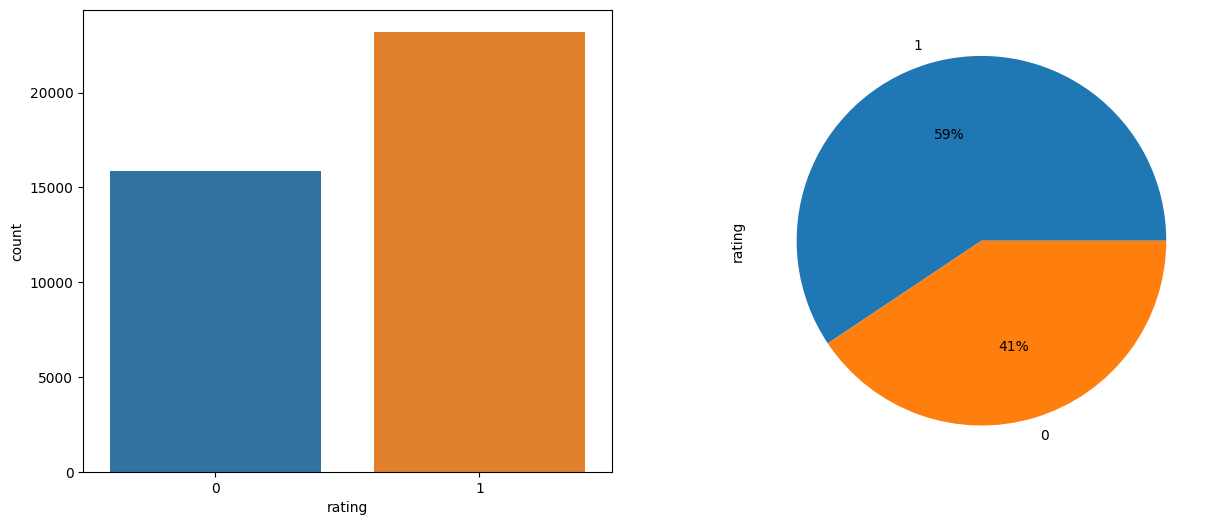

In [11]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=text_df['rating'])
plt.subplot(1, 2, 2)
text_df['rating'].value_counts().plot.pie(autopct='%1.0f%%')

In [12]:
df.groupby('company').size()

company
Ezz Steel           49
Raya               268
TMG                250
capiter             73
domty                4
elsewedy           147
hilton             100
nestle              18
swvl              4693
talbat           32073
telecom_egypt     2090
venus              281
dtype: int64

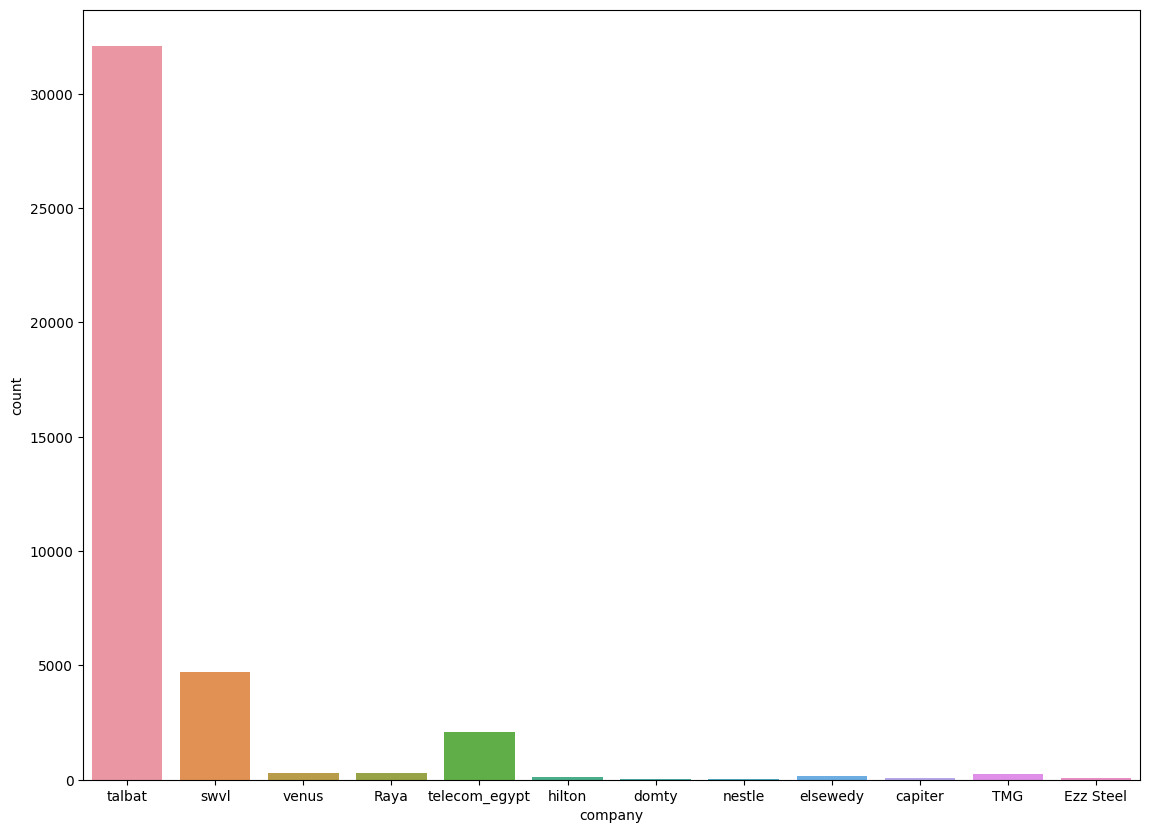

In [13]:
plt.figure(figsize = (30,10))
plt.subplot(1, 2, 1)
sns.countplot(x = df['company'], data = df)

plt.show()

In [14]:
text_df.groupby(['rating']).count()

,review_description
rating,
0,15884
1,23211


In [15]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class
df_majority = text_df[(text_df['rating']==1)]
df_minority = text_df[(text_df['rating']==0)]

# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples=23000 , # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

<Axes: ylabel='rating'>

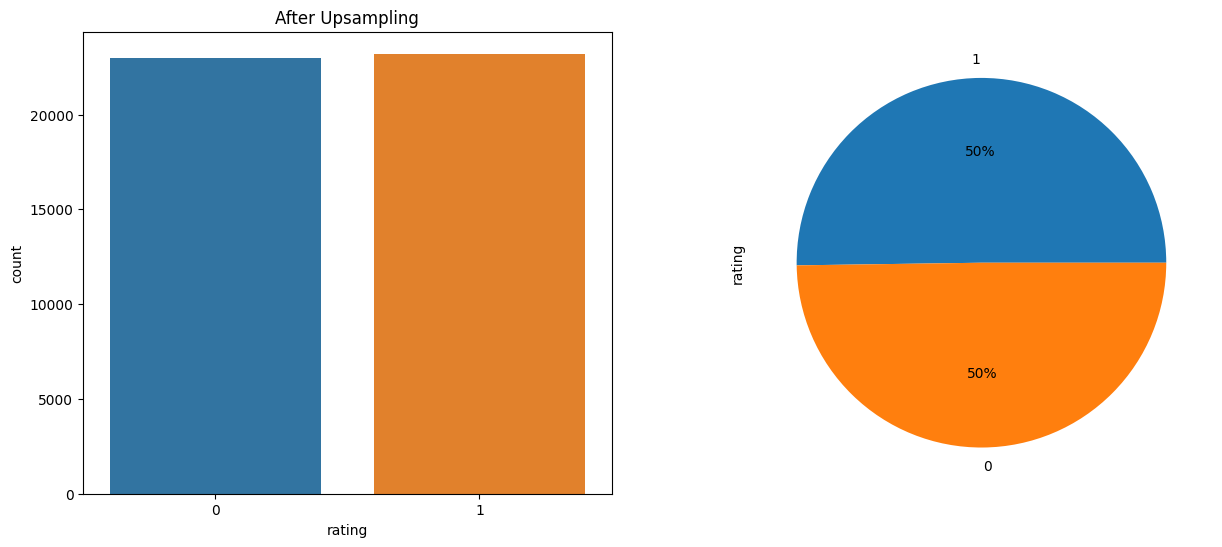

In [16]:
plt.figure(figsize = (15, 6))
ax=plt.subplot(1, 2, 1)
sns.countplot(x=df_upsampled['rating'])
ax.set_title('After Upsampling')
plt.subplot(1, 2, 2)
df_upsampled['rating'].value_counts().plot.pie(autopct='%1.0f%%')

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_upsampled['review_description'],
                                                    df_upsampled['rating'],
                                                    random_state=1)

print('Number of rows in the total set: {}'.format(df_upsampled.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

Number of rows in the total set: 46211
Number of rows in the training set: 34658
Number of rows in the test set: 11553


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

In [19]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(x_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(x_test)

In [20]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data.toarray(), y_train)

MultinomialNB()

In [21]:
predictions = naive_bayes.predict(testing_data.toarray())

In [22]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.8641045615857353
Precision score:  0.8699401619148187
Recall score:  0.8560789747142362
F1 score:  0.8629539106145251


In [23]:
test1=["أنا أحب موقع الملابس الإلكتروني هذا! يوفر تشكيلة رائعة من الملابس العصرية والجودة عالية. كما أنه يوفر خدمة توصيل سريعة وموثوقة. أنصح الجميع بتجربته!",
       "تجربتي مع هذا الموقع كانت سيئة جدًا. لقد تلقيت منتجًا غير مطابق للصورة، والجودة كانت سيئة للغاية. لم يتم استجابة لشكواي بشكل مناسب ولم يتم توفير حلاً مناسبًا. لن أعود للشراء من هذا الموقع مرة أخرى.",
    "أنا غير راضٍ عن خدمة العملاء في هذا الموقع. كانت التجربة غير مرضية، ولم يتم التعامل مع استفساراتي بشكل لائق. بالإضافة إلى ذلك، تأخرت عملية التوصيل بشكل كبير ولم يتم تقديم أي اعتذار. لا أنصح بهذا الموقع."]

In [24]:
test2=count_vector.transform(test1)

In [26]:
res=naive_bayes.predict(test2.toarray())

In [27]:
for i in res:
  if i==0:
    print("Negative")
  else:
    print("positive")

positive
Negative
Negative


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(training_data, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.88
Best parameters:  {'C': 10}


In [33]:
from sklearn.linear_model import LogisticRegression

# Instantiate LogisticRegression with the desired 'C' value
logreg = LogisticRegression(C=10, max_iter=1000)

# Fit the model to the training data
logreg.fit(training_data, y_train)

# Predict on the test data
y_pred1 = logreg.predict(testing_data)

Confusion Matrix: 
Accuracy score:  0.8924088981217
Precision score:  0.894342906875544
Recall score:  0.8898510564599931
F1 score:  0.8920913273721678


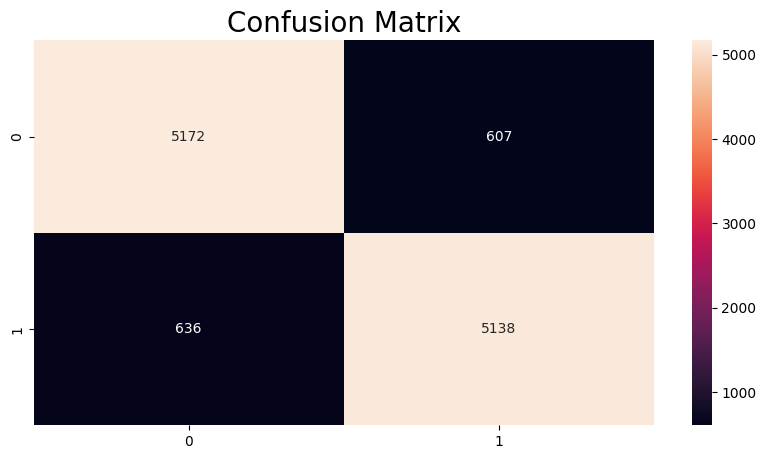

In [34]:
print("Confusion Matrix: ")
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20)
print('Accuracy score: ', format(accuracy_score(y_test, y_pred1)))
print('Precision score: ', format(precision_score(y_test, y_pred1)))
print('Recall score: ', format(recall_score(y_test, y_pred1)))
print('F1 score: ', format(f1_score(y_test, y_pred1)))

In [36]:
test2=["أنا أحب موقع الملابس الإلكتروني هذا! يوفر تشكيلة رائعة من الملابس العصرية والجودة عالية. كما أنه يوفر خدمة توصيل سريعة وموثوقة. أنصح الجميع بتجربته!",
       "تجربتي مع هذا الموقع كانت سيئة جدًا. لقد تلقيت منتجًا غير مطابق للصورة، والجودة كانت سيئة للغاية. لم يتم استجابة لشكواي بشكل مناسب ولم يتم توفير حلاً مناسبًا. لن أعود للشراء من هذا الموقع مرة أخرى.",
    "أنا غير راضٍ عن خدمة العملاء في هذا الموقع. كانت التجربة غير مرضية، ولم يتم التعامل مع استفساراتي بشكل لائق. بالإضافة إلى ذلك، تأخرت عملية التوصيل بشكل كبير ولم يتم تقديم أي اعتذار. لا أنصح بهذا الموقع."]

In [37]:
test2=count_vector.transform(test2)
res2=naive_bayes.predict(test2.toarray())

In [38]:
for i in res:
  if i==0:
    print("Negative")
  else:
    print("positive")

positive
Negative
Negative


In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:

# Create a dictionary of hyperparameters to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Instantiate DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Create GridSearchCV object with the classifier and parameter grid
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(training_data, y_train)

# Retrieve the best model and its hyperparameters
print(grid_search.best_estimator_)
print(grid_search.best_params_)

DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [41]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=10)

# Fit the model to the training data
dt_classifier.fit(training_data, y_train)

# Predict on the test data
y_pred3 = dt_classifier.predict(testing_data)

Confusion Matrix: 
Accuracy score:  0.8775209902189908
Precision score:  0.8814983371258533
Recall score:  0.8721856598545202
F1 score:  0.8768172716984418


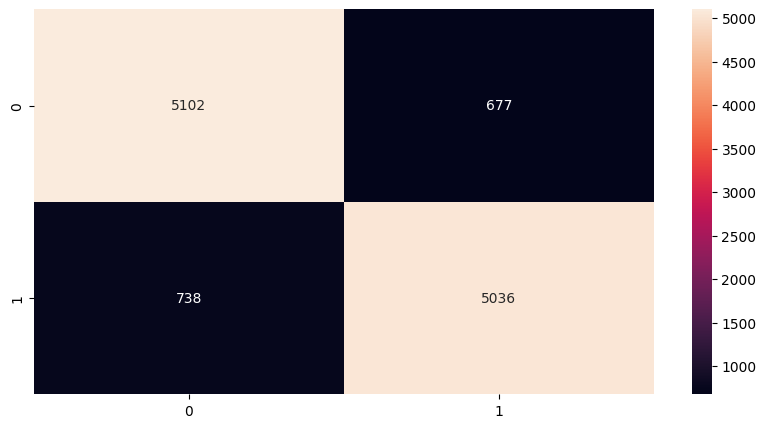

In [42]:
print("Confusion Matrix: ")
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True, fmt='g');
print('Accuracy score: ', format(accuracy_score(y_test, y_pred3)))
print('Precision score: ', format(precision_score(y_test, y_pred3)))
print('Recall score: ', format(recall_score(y_test, y_pred3)))
print('F1 score: ', format(f1_score(y_test, y_pred3)))

In [48]:
test3=["أنا أحب موقع الملابس الإلكتروني هذا! يوفر تشكيلة رائعة من الملابس العصرية والجودة عالية. كما أنه يوفر خدمة توصيل سريعة وموثوقة. أنصح الجميع بتجربته!",
       "تجربتي مع هذا الموقع كانت سيئة جدًا. لقد تلقيت منتجًا غير مطابق للصورة، والجودة كانت سيئة للغاية. لم يتم استجابة لشكواي بشكل مناسب ولم يتم توفير حلاً مناسبًا. لن أعود للشراء من هذا الموقع مرة أخرى.",
    "أنا غير راضٍ عن خدمة العملاء في هذا الموقع. كانت التجربة غير مرضية، ولم يتم التعامل مع استفساراتي بشكل لائق. بالإضافة إلى ذلك، تأخرت عملية التوصيل بشكل كبير ولم يتم تقديم أي اعتذار. لا أنصح بهذا الموقع."]

In [49]:
test2=count_vector.transform(test3)
test2.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
res3=dt_classifier.predict(test2.toarray())

In [51]:
for i in res3:
  if i==0:
    print("Negative")
  else:
    print("positive")

positive
Negative
Negative
